# Multiway Cluster Robust Double/Debiased Machine Learning

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_data

## Generate data using the example from Chiang et al. (2020) https://arxiv.org/pdf/1909.03489.pdf



As data generating process Chiang et al. (2020) consider

$$


In [20]:
# simulation parameters
N = 25 # number of observations (first dimension)
M = 25 # number of observations (second dimension)
dim_X = 100 # dimenson of X

data = make_pliv_multiway_cluster_data(N, M, dim_X)

In [21]:
# data with multi index for rows (tuples with two entries)
data.head(30)

Y         D         Z         V        x1        x2        x3  \
0 0  -3.104172 -1.992036 -0.505658 -0.335077  0.165088 -0.475318 -0.405970   
  1  -1.195087 -1.128171 -0.956224 -0.501446 -0.865256  0.276429 -0.209621   
  2   0.768155  1.112844  0.768127  0.663155  0.096541  0.450747 -0.599125   
  3  -0.459350  1.002150 -0.104190  0.221441 -0.203236 -0.229027 -0.514751   
  4  -1.380409 -0.308991 -0.814082 -0.910359  0.394664 -0.747230  0.258384   
  5   1.912823  1.739965  1.010915  0.633758  0.323235  0.892101 -0.369513   
  6  -0.782401 -0.283049 -0.169701  0.044187 -0.062323 -0.376634 -0.468896   
  7   0.929466  1.880979  1.786240  1.251403  1.110544  0.031630 -0.597033   
  8  -1.217052 -0.245651 -0.616068 -0.762776  0.040516  0.303718  0.404375   
  9  -3.038590 -2.321359 -0.708026 -0.086257 -0.918195 -0.429508 -0.447156   
  10 -0.788078  0.219971 -0.151374 -0.308433  0.060229  0.270465  0.478680   
  11  0.878976  1.151071  0.637838  0.308021  0.145404  0.591031  1.127005   
  12  1.845381  1.899393  0.774856  0.583226  0.024406  0.781588  0.046187   
  13 -2.898408 -1.138920 -0.099648  0.323600 -0.269942 -0.174481 -1.111269   
  14 -0.617203 -0.323044 -0.045443 -0.060351  0.302849 -0.362335  0.150914   
  15 -1.881798 -1.840096 -1.006348 -0.836579 -0.240597  0.106848 -0.327902   
  16  0.292197  0.832797  0.355978  0.453980 -0.379990  0.126071  0.323379   
  17  0.489554  0.902584 -0.190520  0.112810 -0.113450 -0.184643 -0.890758   
  18 -1.365201 -0.488846  0.192466  0.773923 -0.932644 -0.445049 -0.279242   
  19 -0.700149  0.880188  1.349110  1.064731  0.287473  0.711032  0.549177   
  20  4.395469  3.244484  1.104732  0.311913  1.510163  0.104521  0.292326   
  21 -0.755249 -0.621656 -0.593884 -0.122812 -0.612623 -0.405536  0.133292   
  22  1.903406  1.412513  0.745642  0.503340  0.570498 -0.359151 -0.170724   
  23 -2.153301 -0.748174 -0.069187  0.134127 -0.139010 -0.925650  0.781617   
  24 -1.283707 -0.827353 -0.314923 -0.431025  0.422879 -0.214652 -0.113763   
1 0  -1.317586 -1.475049 -0.315859 -0.398481  0.637165 -0.651021 -0.035554   
  1  -0.517672 -0.996819 -0.413895 -0.343534 -0.094428  0.654615 -0.488052   
  2   0.143958  0.032334  0.086104  0.035039  0.018418  0.233295 -0.138746   
  3   1.668320  1.881021  0.870743  0.690638  0.781233 -0.170255 -0.476214   
  4   0.070441  0.456696 -0.161095 -0.383660  0.752748 -0.594319 -0.104210   

            x4        x5        x6  ...       x91       x92       x93  \
0 0  -0.633937 -1.111839 -0.330665  ...  0.302997 -0.863426 -0.734583   
  1  -0.280781 -0.983920 -0.744120  ... -0.684354 -0.613281  0.573834   
  2   0.986029 -0.599964 -0.357237  ...  0.261251 -0.159076  0.617991   
  3  -0.922530 -1.328223  0.116821  ...  0.130443  0.720251  0.553523   
  4   0.773697  0.583169 -0.113752  ... -0.011415 -1.081030  0.162924   
  5   0.448371  0.356383  0.458323  ... -0.707280 -0.288972 -0.382926   
  6  -0.744005  0.509000  0.508741  ... -0.311559 -0.749193 -0.571612   
  7   0.731580  0.315065 -0.333456  ... -0.109255 -0.924123 -0.092199   
  8   0.154926 -0.314527  0.473351  ... -0.191555  0.198862 -0.017501   
  9   0.554742 -0.881392 -0.217624  ... -0.639224 -1.489094  0.180896   
  10  0.569081 -0.722309 -0.482249  ...  0.081200 -0.310204 -0.693622   
  11 -0.143023 -0.905921  0.494036  ...  0.528881 -0.101072 -0.049845   
  12  0.344339 -1.052454 -0.019805  ...  0.105441 -0.011932  0.060119   
  13 -1.053526 -1.405476  0.147264  ...  0.766891 -0.857858 -0.123155   
  14 -0.431644 -1.322604  0.376070  ...  0.591629  0.294868 -0.298707   
  15 -0.018840 -0.646165 -0.093939  ...  0.364202  0.257035  0.766040   
  16  0.639626 -0.310503 -0.009421  ...  0.596448 -0.278141  0.248337   
  17 -0.755696 -1.037397 -0.374461  ...  0.005400  0.098838  0.480294   
  18  0.769268 -0.119956 -0.808171  ...  0.819689  0.098401 -0.568323   
  19 -0.677108 -1.287606 -0.664128  ...  0.189552  0.687386 -0.334862   
  20 -0.203883 -0.283750 -0.263182  ...  0.121822 -0.314395  

## Initialize the objects of class DoubleMLData and DoubleMLPLIV

In [22]:
# collect data
x_cols = data.columns[data.columns.str.startswith('x')].tolist()

# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_learners = {'ml_m': clone(learner),
               'ml_g': clone(learner),
               'ml_r': clone(learner)}

obj_dml_data = DoubleMLData(data, 'Y', 'D', x_cols, 'Z')

dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_learners,
                            inf_model='DML2018',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object

In [23]:
K = 3 # number of folds

smpl_sizes = [N, M]

obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)

smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

In [24]:
dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and return the fitted parameter

In [25]:
dml_pliv_obj.fit()

In [26]:
dml_pliv_obj.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
D,1.101326,0.039065,28.19196,7.337551e-175,1.02476,1.177893


## Visualization of sample splitting with tuple and linear indexing

In [11]:
from matplotlib.colors import ListedColormap

#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])

In [12]:
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)

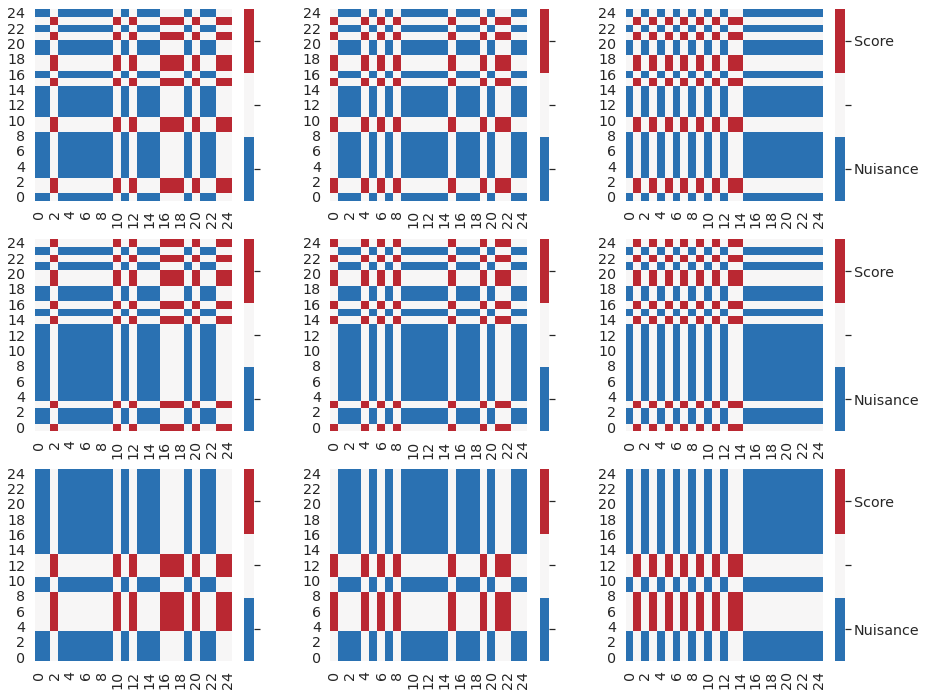

In [13]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split+1)
    df = pd.DataFrame(np.zeros([N,M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.
    
    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K-1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)

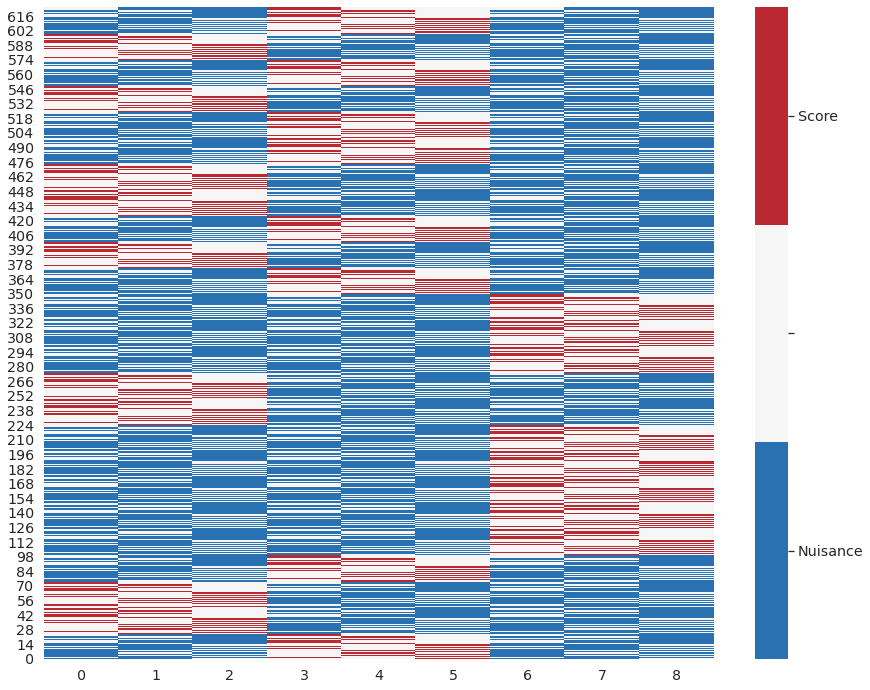

In [14]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])